In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import biopsykit as bp

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from fau_colors import register_cmaps

register_cmaps()

sns.set_theme(context="poster", style="white", palette="faculties", font_scale=1.2)

%matplotlib widget

In [6]:
from sleep_analysis.preprocessing.utils import extract_edf_channel
from sleep_analysis.preprocessing.mesa_dataset.edr import _extract_edr
import json
from sleep_analysis.feature_extraction.mesa_datasst.rrv import process_resp, extract_rrv_features_helper

In [8]:
with open(Path.cwd().parents[1].joinpath("study_data.json")) as f:
    path_dict = json.load(f)
    edf_path = Path(path_dict["mesa_path"]).joinpath("polysomnography/edfs")
    processed_mesa_path = Path(path_dict["processed_mesa_path_local"])

# EDR

In [9]:
raw_ecg, epochs = extract_edf_channel(edf_path, subj_id=int(1), channel="EKG")

Extracting EDF parameters from /Volumes/INTENSO/datasets/mesa/polysomnography/edfs/mesa-sleep-0001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [10]:
downsample_ecg = bp.utils.array_handling.downsample(np.asarray(raw_ecg), 256, 32)
downsample_ecg = pd.DataFrame(downsample_ecg).rename(columns={0: "ECG"})
downsample_ecg = downsample_ecg * (-1)

In [11]:
edr_signal = _extract_edr(raw_ecg, sampling_rate=256)
edr_df, epochs = process_resp(edr_signal.respiratory_signal, epochs)

  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
edr_df = edr_df.rename(columns={0: "EDR"})

# Thor

In [13]:
resp_df, epochs = extract_edf_channel(edf_path, subj_id=int(1), channel="Thor")

Extracting EDF parameters from /Volumes/INTENSO/datasets/mesa/polysomnography/edfs/mesa-sleep-0001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [14]:
resp_df, epochs = process_resp(resp_df, epochs)

In [15]:
resp_df = resp_df.rename(columns={0: "Respiration"})

# Plotting

/var/folders/kr/z18bsf7n4xsf9cd__hgnn7lh0000gn/T/ipykernel_96509/2717555560.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=30)


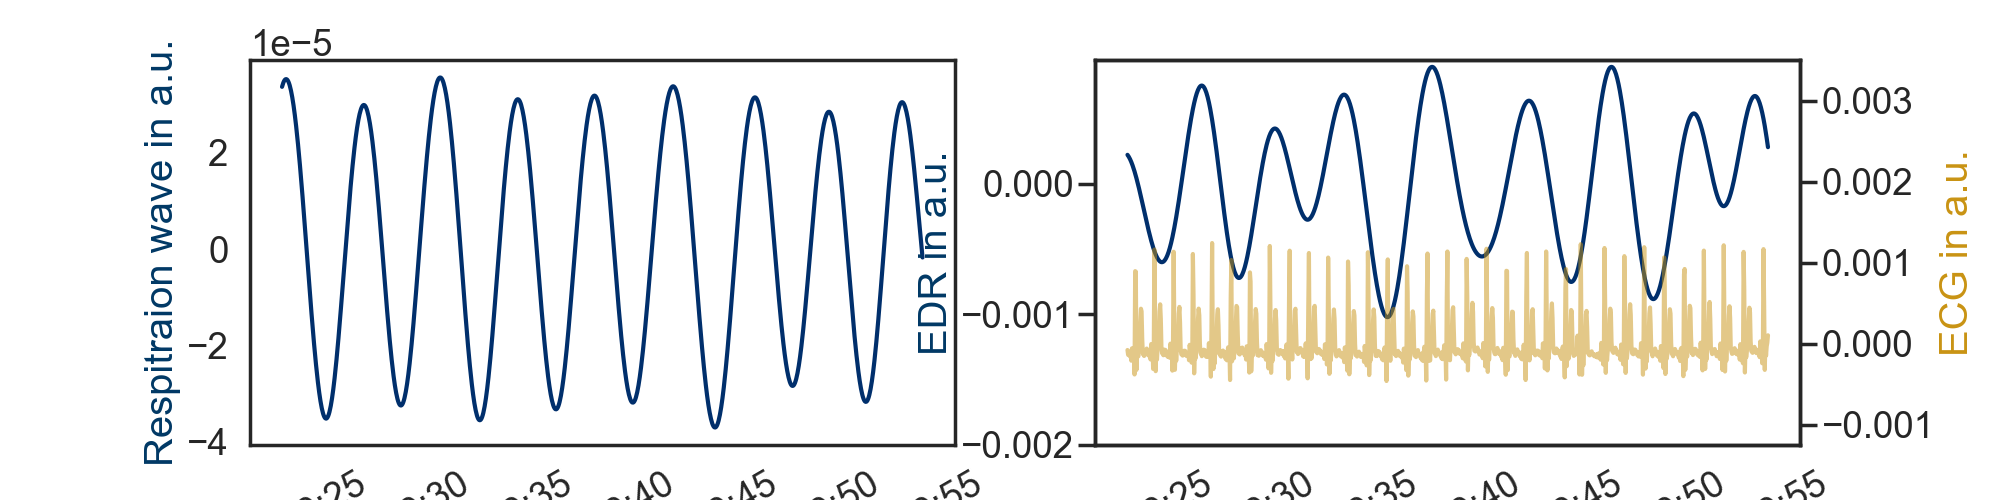

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=((20, 5)))
sns.lineplot(x=resp_df[500000:501000].index, y=resp_df[500000:501000]["Respiration"], ax=axs[0])
sns.lineplot(x=edr_df[500000:501000].index, y=edr_df[500000:501000]["EDR"], ax=axs[1])
ax_2 = axs[1].twinx()
sns.lineplot(x=edr_df[500000:501000].index, y=downsample_ecg[500000:501000]["ECG"], ax=ax_2, alpha=0.5, color="#c99313")
ax_2.set_ylim(-0.00125, 0.0035)
axs[1].set_ylim(-0.002, 0.00095)
# axs[0].set_title("Respiration wave recorded via a thoracic belt")
# axs[1].set_title("Respiration wave extracted from ECG via EDR")
axs[0].set_ylabel("Respitraion wave in a.u.", color="#003865")
axs[1].set_ylabel("EDR in a.u.", color="#003865")
ax_2.set_ylabel("ECG in a.u.", color="#c99313")
for ax in axs:
    labels = ax.get_xticklabels()
    ax.set_xticklabels(labels, rotation=30)

# Don't save anymore because its an old image
# plt.savefig("edr_extraction.pdf", format="pdf", bbox_inches="tight")

In [17]:
def normalize(df, column):
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    return df

In [18]:
edr_df_slice = edr_df[500000:501000]
downsample_ecg_slice = downsample_ecg[500000:501000]
resp_df_slice = resp_df[500000:501000]
edr_df_slice = normalize(edr_df_slice, "EDR")
downsample_ecg_slice = normalize(downsample_ecg_slice, "ECG")
resp_df_slice = normalize(resp_df_slice, "Respiration")

/var/folders/kr/z18bsf7n4xsf9cd__hgnn7lh0000gn/T/ipykernel_96509/1537868134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())


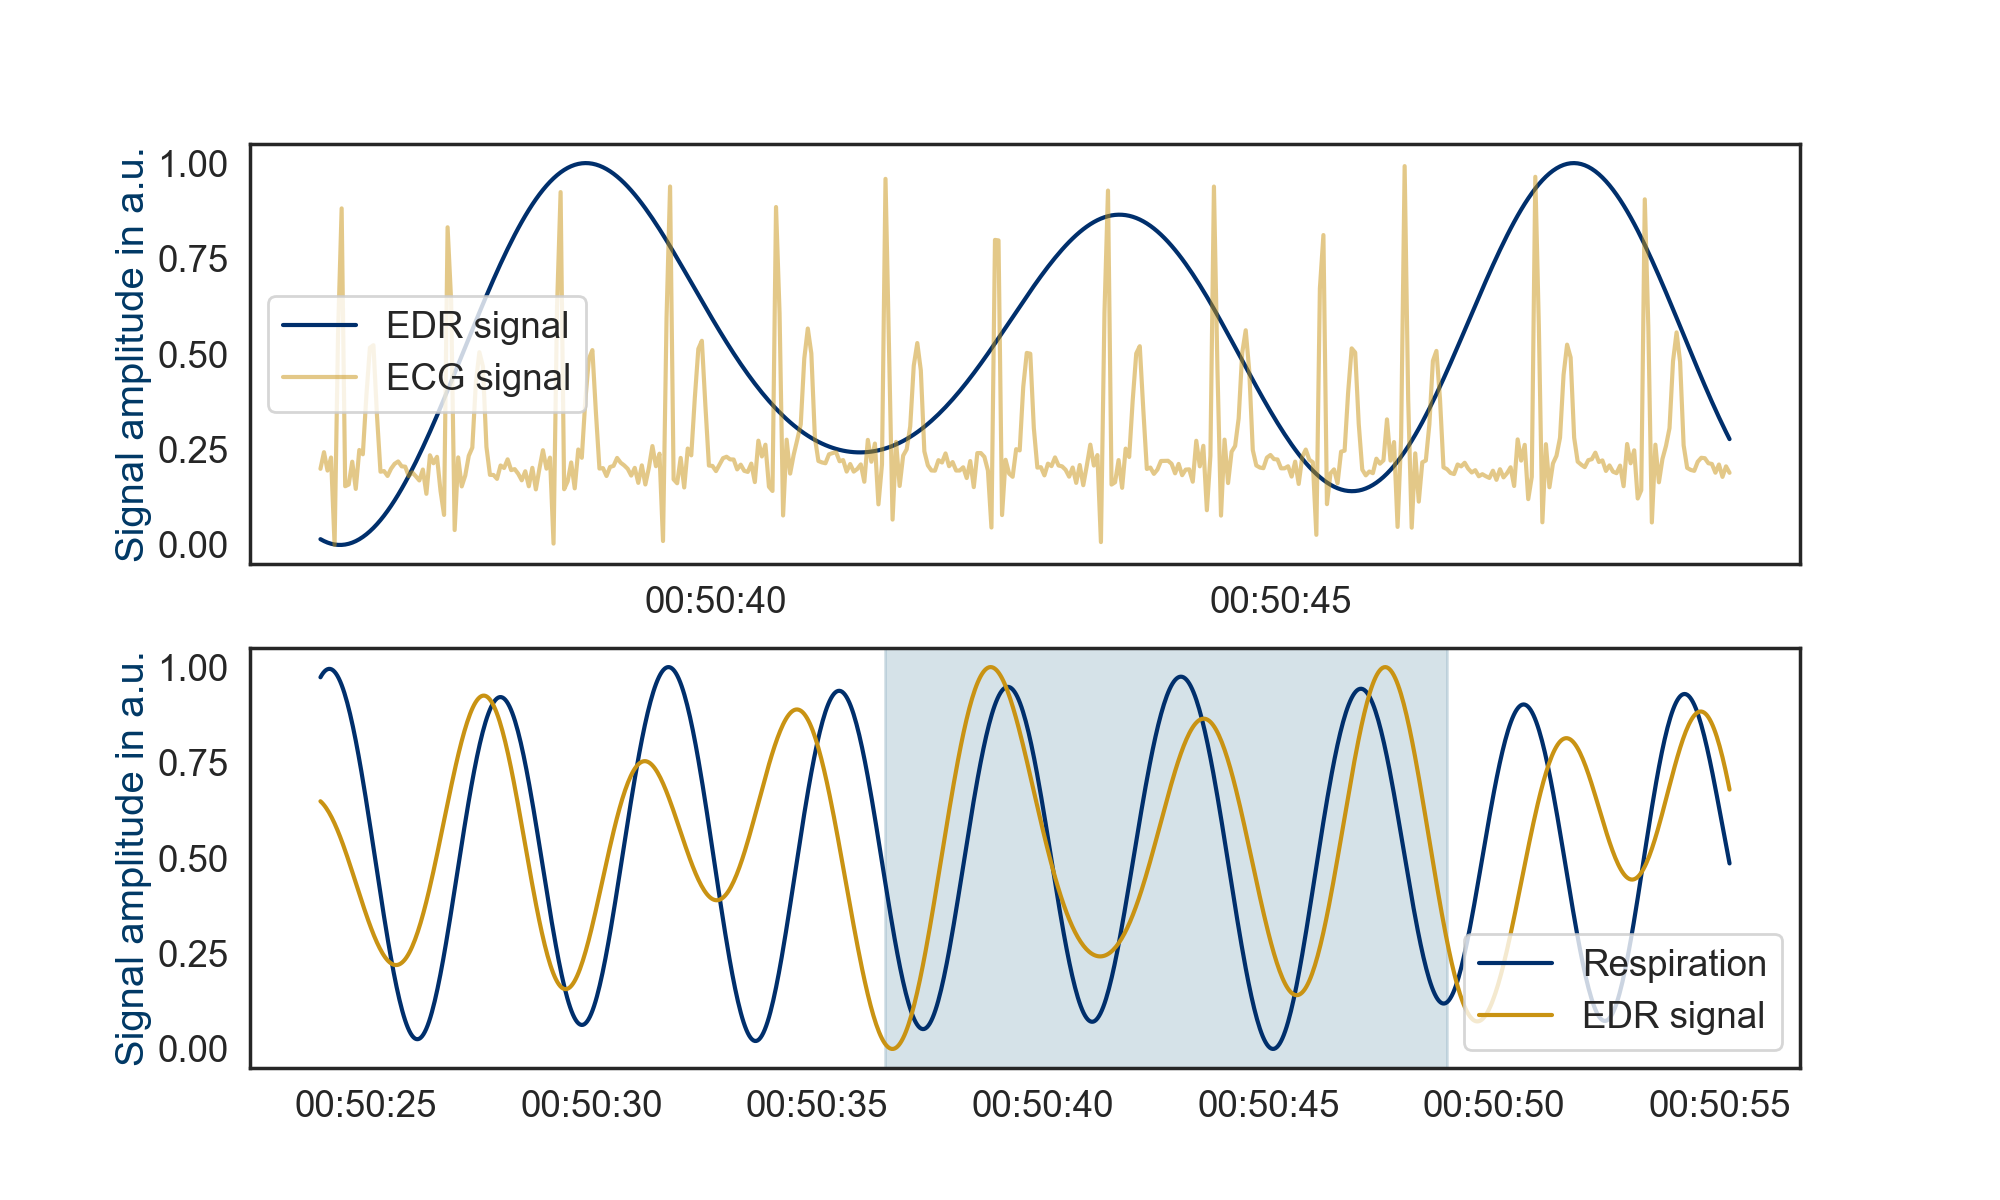

In [19]:
fig, axs = plt.subplots(nrows=2, figsize=((20, 12)))

sns.lineplot(x=edr_df_slice[400:800].index, y=edr_df_slice[400:800]["EDR"], ax=axs[0], label = "EDR signal")
sns.lineplot(x=edr_df_slice[400:800].index, y=downsample_ecg_slice[400:800]["ECG"], ax=axs[0], alpha=0.5, color="#c99313", label = "ECG signal")

sns.lineplot(x=resp_df_slice[:1000].index, y=resp_df_slice[:1000]["Respiration"], ax=axs[1], label="Respiration")
sns.lineplot(x=edr_df_slice[:1000].index, y=edr_df_slice[:1000]["EDR"], ax=axs[1], color="#c99313", label="EDR signal")

ax = axs[1].axvspan("1985-01-02 00:50:36.500000", "1985-01-02 00:50:48.968750016", color="#779FB5", alpha=0.3)


axs[0].set_ylabel("Signal amplitude in a.u.", color="#003865")
axs[1].set_ylabel("Signal amplitude in a.u.", color="#003865")

plt.savefig("edr_extraction.pdf", format="pdf", bbox_inches="tight")

In [20]:
resp_df_slice

,Respiration
1985-01-02 00:50:24.000000000,0.973293
1985-01-02 00:50:24.031249984,0.979675
1985-01-02 00:50:24.062499968,0.984991
1985-01-02 00:50:24.093750016,0.989226
1985-01-02 00:50:24.125000000,0.992366
...,...
1985-01-02 00:50:55.093750016,0.563774
1985-01-02 00:50:55.125000000,0.543976
1985-01-02 00:50:55.156249984,0.524333
1985-01-02 00:50:55.187500032,0.504909


In [21]:
resp_df

,Respiration
1985-01-01 20:29:59.000000000,-2.667448e-05
1985-01-01 20:29:59.031249984,-3.387395e-05
1985-01-01 20:29:59.062499968,-4.076674e-05
1985-01-01 20:29:59.093750016,-4.769543e-05
1985-01-01 20:29:59.125000000,-5.430683e-05
...,...
1985-01-02 08:29:57.843750016,7.798759e-09
1985-01-02 08:29:57.875000000,6.359991e-09
1985-01-02 08:29:57.906249984,5.257168e-09
1985-01-02 08:29:57.937500032,4.488034e-09


In [22]:
edr_df_slice

,EDR
1985-01-02 00:50:24.000000000,0.648619
1985-01-02 00:50:24.031249984,0.645048
1985-01-02 00:50:24.062499968,0.640959
1985-01-02 00:50:24.093750016,0.636357
1985-01-02 00:50:24.125000000,0.631248
...,...
1985-01-02 00:50:55.093750016,0.748392
1985-01-02 00:50:55.125000000,0.732153
1985-01-02 00:50:55.156249984,0.715168
1985-01-02 00:50:55.187500032,0.697478
